In [21]:
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt


def extract_bounding_box(image_path, xml_path):
    # Load the image
    image = cv2.imread(image_path)

    # Parse the XML file
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Extract bounding box coordinates
    for obj in root.findall(".//object"):
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)

        # Crop the bounding box from the image
        cropped_image = image[ymin:ymax, xmin:xmax]

        # Save or display the cropped image
    plt.imshow(image)
    # plt.imshow(cropped_image)


# Example usage
image_path = "archive(2)/05102009102.jpg"
xml_path = "archive(2)/05102009102.xml"


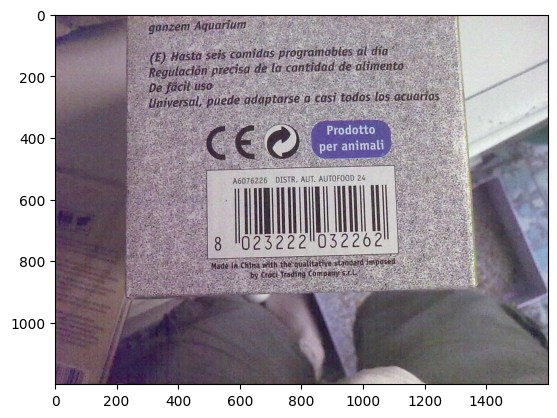

In [22]:
extract_bounding_box(image_path, xml_path)

In [23]:
import os
import shutil


def move_xml_files(source_dir, destination_dir):
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Iterate through all files in the source directory
    for file in os.listdir(source_dir):
        if file.endswith(".xml"):
            source_path = os.path.join(source_dir, file)
            destination_path = os.path.join(destination_dir, file)

            # Move the XML file
            shutil.move(source_path, destination_path)


# Example usage
source_directory = "archive(2)"
destination_directory = "xml_files"

move_xml_files(source_directory, destination_directory)

In [24]:
import cv2
import os
import xml.etree.ElementTree as ET


def extract_bounding_boxes(image_dir, xml_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate through all XML files
    for xml_file in os.listdir(xml_dir):
        if not xml_file.endswith(".xml"):
            continue

        # Parse the XML file
        xml_path = os.path.join(xml_dir, xml_file)
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Load the corresponding image
        image_file = root.find(".//filename").text
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)

        # Extract bounding boxes
        for i, obj in enumerate(root.findall(".//object")):
            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)

            # Crop the bounding box from the image
            cropped_image = image[ymin:ymax, xmin:xmax]

            # Generate a unique filename for each cropped barcode
            output_filename = f"{os.path.splitext(image_file)[0]}_barcode_{i}.jpg"
            output_path = os.path.join(output_dir, output_filename)

            # Save the cropped image
            cv2.imwrite(output_path, cropped_image)


# Example usage
image_directory = "archive(2)"
xml_directory = "xml_files"
output_directory = "barcode_images"

extract_bounding_boxes(image_directory, xml_directory, output_directory)


In [1]:
import cv2
import numpy as np

def calculate_optimal_layers(image):
    height, width = image.shape[:2]
    # Number of layers depends on the smallest dimension
    return int(np.log2(min(height, width))) - 1

img = cv2.imread('barcode_images/05102009102_barcode_1.jpg', cv2.IMREAD_GRAYSCALE)
num_layers = calculate_optimal_layers(img)
print("Optimal Layers:", num_layers)


Optimal Layers: 5


In [1]:
import cv2
import numpy as np
from realesrgan import RealESRGAN
import matplotlib.pyplot as plt
img = cv2.imread('blurry_barcode.jpg', cv2.IMREAD_GRAYSCALE)

def laplacian_pyramid(img, levels=7):
    gaussian_pyr = [img]
    for i in range(levels):
        img = cv2.GaussianBlur(img, (5, 5), 0)
        gaussian_pyr.append(img)
    return gaussian_pyr

def focus_stack(layers):
    sharp_layers = []
    for layer in layers[3:]:  # Skip low frequencies
        edges = cv2.Laplacian(layer, cv2.CV_64F)
        sharp_layers.append(edges)
    return sum(sharp_layers) / len(sharp_layers)

def enhance_with_esrgan(image):
    model = RealESRGAN('RealESRGAN_x4plus')
    return model.predict(image)

pyramid = laplacian_pyramid(img)

sharp_image = focus_stack(pyramid)

enhanced = enhance_with_esrgan(sharp_image)

# Plot all 3 images
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title("Original Blurry Barcode")
plt.imshow(img, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("After Focus Stacking")
plt.imshow(sharp_image, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Final Unblurred Barcode (ESRGAN Enhanced)")
plt.imshow(enhanced, cmap='gray')

plt.show()

ModuleNotFoundError: No module named 'torchvision.transforms.functional_tensor'

In [19]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def align_image(image, reference):
    sift = cv2.SIFT_create()

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_reference = cv2.cvtColor(reference, cv2.COLOR_BGR2GRAY)

    kp1, des1 = sift.detectAndCompute(gray_image, None)
    kp2, des2 = sift.detectAndCompute(gray_reference, None)

    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    if len(good_matches) < 4:
        print("⚠️ Not enough keypoints for alignment!")
        return np.zeros_like(image)  

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    matrix, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    aligned = cv2.warpPerspective(image, matrix, (reference.shape[1], reference.shape[0]))

    return aligned


def extract_high_freq(image):
    blurred = cv2.GaussianBlur(image, (15, 15), 5)
    return cv2.subtract(image, blurred)

def get_reference_image(blurry_images):
    def high_freq_content(img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return cv2.Laplacian(gray, cv2.CV_64F).var()

    high_freq_values = [high_freq_content(img) for img in blurry_images]

    return blurry_images[np.argmax(high_freq_values)]


def multi_frame_fusion(blurry_images):
    reference = get_reference_image(blurry_images)
    fused = np.zeros_like(reference, dtype=np.float32)

    for img in blurry_images:
        aligned_img = align_image(img, reference)
        high_freq = extract_high_freq(aligned_img)

        high_freq = cv2.warpPerspective(high_freq, np.eye(3), (reference.shape[1], reference.shape[0]))

        fused += high_freq

    fused = cv2.normalize(fused, None, 0, 1, cv2.NORM_MINMAX)#.astype(np.uint)

    return fused

blurry_images = os.listdir("deblurred_stack_images/nb_1")
blurry_images

['Screenshot from 2025-03-16 18-03-38.png',
 'Screenshot from 2025-03-16 18-05-47.png',
 'Screenshot from 2025-03-16 18-05-14.png',
 'Screenshot from 2025-03-16 18-04-32.png',
 'Screenshot from 2025-03-16 18-07-28.png',
 'Screenshot from 2025-03-16 18-06-03.png',
 'Screenshot from 2025-03-16 18-06-44.png',
 'Screenshot from 2025-03-16 18-04-13.png',
 'Screenshot from 2025-03-16 18-07-40.png',
 'Screenshot from 2025-03-16 18-06-19.png',
 'Screenshot from 2025-03-16 18-04-00.png',
 'Screenshot from 2025-03-16 18-07-13.png',
 'Screenshot from 2025-03-16 18-03-48.png',
 'Screenshot from 2025-03-16 18-04-52.png',
 'Screenshot from 2025-03-16 18-03-29.png']

In [20]:
blurr = []
for image in blurry_images:
    blurr.append(cv2.imread(os.path.join("deblurred_stack_images/nb_1", image)))
len(blurr)

15

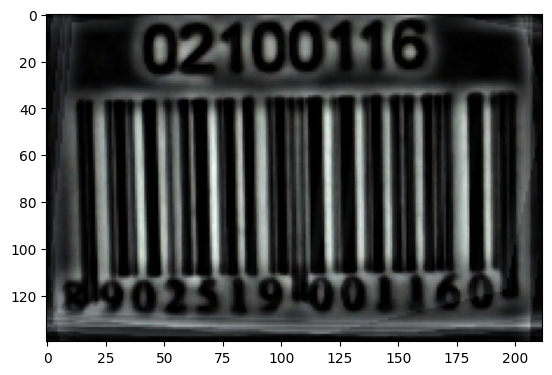

In [21]:
sharp_image = cv2.imread('clicked_dataset/nb_1.png')

reconstructed_image = multi_frame_fusion(blurr)
plt.imshow(reconstructed_image)


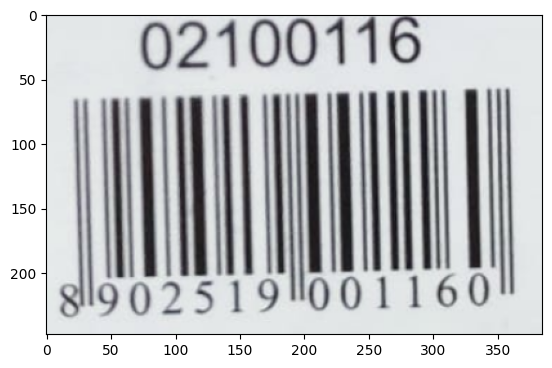

In [4]:
plt.imshow(sharp_image)

In [10]:
image = cv2.imread("clicked_dataset/nb_1/Screenshot from 2025-03-16 18-03-38.png")
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(image, None)

In [4]:
!python predict.py

  0%|                                                     | 0/1 [00:00<?, ?it/s][ WARN:0@4.763] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
/home/roy/unblur_Barcode/DeblurGANv2/models/fpn_inception.py:164: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  map3 = self.td1(lateral3 + nn.functional.upsample(map4, scale_factor=2, mode="nearest"))
/home/roy/unblur_Barcode/DeblurGANv2/models/fpn_inception.py:165: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  map2 = self.td2(F.pad(lateral2, pad, "reflect") + nn.functional.upsample(map3, scale_factor=2, mode="nearest"))
/home/roy/unblur_Barcode/DeblurGANv2/models/fpn_inception.py:166: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  map1 = self.td3(lateral1 + nn.functional.upsample(map2, scale_factor=2, mode="nearest"))
/home/roy/unblur_Barcode/Deblur

In [5]:
!python deblurring.py